# Required libs

In [2]:
%pylab inline

import pandas as pd
import seaborn as sns
from pathlib import Path
from lxml import etree


Populating the interactive namespace from numpy and matplotlib


# Initial parsing

Downloaded the clinicaltrials.gov data from https://clinicaltrials.gov/ct2/resources/download

The whole thing comes in a zip file called **AllPublicXML.zip** and contains directories named NCTXXXXxxxx that contain a xml file per study, organized by nct codes.

We parse the directory structure using **pathlib** and individual xml files using **lxml**. 

Parsed Data : 
 * NCT id (unique)
 * study type (interventional/observational etc.)
 * overall_status 
 * Phase (1|1/2|2|2/3|3|4) 
 * conditions 
 * drug names (intervention_name fields where intervention_type is drug)
 * firstreceived_date (this is the only date field that is mandatory)
 * MeSH terms representing conditions
 * MeSH terms representing interventions
 
Note that **neither condition nor drug names are standardized**. MeSH terms are standardized but assigned using * an imperfect algorithm* on clinicaltrials.gov side.

In [6]:
p = Path('../data')

files = p.glob('NCT*xxxx/*.xml')

counter = 0 

trials = list()

nct_id = []
study_type = []
phase = []
overall_status = []
drug_names = []
conditions = []
intervention_mesh = []
condition_mesh = []
start_date = []


for file in files :
    
    root= etree.parse(file.open())
    
    nct_id.append(root.findtext("id_info/nct_id"))
    
    study_type.append(root.findtext("study_type"))
    
    overall_status.append(root.findtext('overall_status'))
    
    phase.append(root.findtext('phase'))

    interventions = root.findall("intervention")
    
    #time = strptime(root.findtext("firstreceived_date"), "%Y, %B")
    
    year =  int(root.findtext("firstreceived_date").split()[-1])
    start_date.append(year)

    d= set()
    for intervention in interventions :
        if intervention.findtext("intervention_type") == "Drug" :
            d.add(intervention.findtext("intervention_name"))
            
    drug_names.append(d)
            

    c = {cond.text for cond in root.findall("condition")}
    
    conditions.append(c)
    
    
    intervention_mesh.append({ term.text for term in root.findall("intervention_browse/mesh_term")})
    condition_mesh.append({ term.text for term in root.findall("condition_browse/mesh_term") })
    

In [58]:
# Making phase data into categorical variable 

catPhase= pd.Categorical(phase, categories=["Early Phase 1", 
                                  "Phase 1", 
                                  "Phase 1/Phase 2", 
                                  "Phase 2", 
                                  "Phase 2/Phase 3", 
                                  "Phase 3", 
                                  "Phase 4"], ordered = True)

# Making study_type and overall_status into categorical variable

catStatus = pd.Categorical(overall_status)

frdate = pd.Series(start_date, dtype=int)

# counting number of interventions, drugs and conditions per trial 

ndrugs = [len(d) for d in drug_names]
ninterventions = [len(meshlist) for meshlist in intervention_mesh]
nconditions = [len(meshlist) for meshlist in condition_mesh]

In [113]:
# convert the whole thing to a dataframe

data = pd.DataFrame(
    index = nct_id, 
    data = {
    'study_type':pd.Categorical(study_type), 
    'overall_status':pd.Categorical(overall_status),
    'firstreceived_date':array(start_date,dtype=int),
    'phase':catPhase,
    'ndrugs': ndrugs,
    'nconditions': nconditions,
    'ninterventions' :ninterventions,
    'conditions':conditions,
    'drugs':drug_names,
    'cond_mesh':condition_mesh,
    'int_mesh':intervention_mesh}
)

#  and save as csv

data.to_csv('alltrials.csv')

Now that we have the data in a dataframe, we can start playing with it. 

We want **interventional** trials that **involve at least 1 drugs**.

In [117]:
# filter for interventional trials that involve drugs 

drugtrials = data[ (data.study_type=='Interventional') & (data.ndrugs>0) ]

# and save as csv

drugtrials.to_csv('drugtrials.csv')
drugtrials.to_json('drugtrials.json')

In [116]:
drugtrials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110693 entries, NCT00090051 to NCT02836288
Data columns (total 11 columns):
cond_mesh             110693 non-null object
conditions            110693 non-null object
drugs                 110693 non-null object
firstreceived_date    110693 non-null int64
int_mesh              110693 non-null object
nconditions           110693 non-null int64
ndrugs                110693 non-null int64
ninterventions        110693 non-null int64
overall_status        110693 non-null category
phase                 99076 non-null category
study_type            110693 non-null category
dtypes: category(3), int64(4), object(4)
memory usage: 7.9+ MB


Data starts at 1999. Registration became mandatory at 2008. 

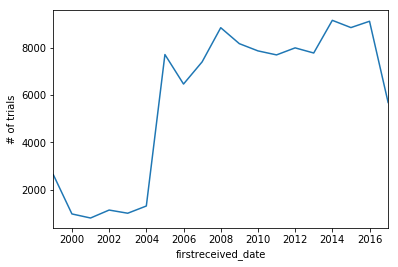

In [112]:
groups = drugtrials.groupby('firstreceived_date')
groups.ndrugs.count().plot()
ylabel("# of trials");

In [29]:
drugconditions = set()
for conds in drugtrials.cond_mesh :
    for c in conds :
        drugconditions.add(c)

drugnames = set()
for drgs in drugtrials.int_mesh: 
    for d in drgs :
        drugnames.add(d)
        
print ('{} unique conditions (mesh terms) attempted by {} unique interventions (mesh_terms). '.format(len(drugconditions), len(drugnames)))


3053 unique conditions (mesh terms) attempted by 2915 unique interventions (mesh_terms). 


1999
HIV Infections 858
Infection 259
Acquired Immunodeficiency Syndrome 200
Lymphoma 175
Communicable Diseases 162
Leukemia 161
Breast Neoplasms 128
Lung Neoplasms 96
Sarcoma 96
Central Nervous System Neoplasms 89

2000
Leukemia 106
Lymphoma 93
HIV Infections 80
Syndrome 69
Lung Neoplasms 67
Breast Neoplasms 52
Preleukemia 49
Myelodysplastic Syndromes 49
Leukemia, Myeloid 43
Carcinoma, Non-Small-Cell Lung 42

2001
HIV Infections 63
Breast Neoplasms 57
Lymphoma 57
Leukemia 57
Lung Neoplasms 49
Colorectal Neoplasms 40
Central Nervous System Neoplasms 36
Nervous System Neoplasms 36
Syndrome 25
Prostatic Neoplasms 25

2002
Breast Neoplasms 78
Lung Neoplasms 74
Leukemia 73
Lymphoma 58
Carcinoma, Non-Small-Cell Lung 55
HIV Infections 51
Neoplasms 47
Leukemia, Myeloid 42
Colorectal Neoplasms 41
Disease 38

2003
Lymphoma 79
Lung Neoplasms 69
Leukemia 65
Breast Neoplasms 65
Carcinoma, Non-Small-Cell Lung 54
Carcinoma 44
Syndrome 43
Lymphoma, Non-Hodgkin 41
HIV Infections 38
Neoplasms 35

2004
